In [42]:
import qiskit as q
from qiskit. visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit_aer import Aer
from qiskit.primitives import BackendSampler
from qiskit.visualization import plot_histogram
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt



In [43]:
def potential_op(N,V,dt):
    """
    constant potential operator of height V and qubit N"""
    qc=q.QuantumCircuit(N)
    qc.p(V*dt,N-1)
    qc=qc.to_gate()
    qc.name ="potential"
    return qc

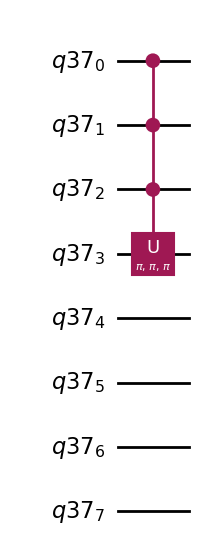

In [44]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.standard_gates import UGate
N=8
qr = QuantumRegister(N)
qc = QuantumCircuit(qr)
c3h_gate = UGate(np.pi,np.pi,np.pi).control(N//2-1)
qc.append(c3h_gate, [qr[0], qr[1], qr[2],qr[3]])
qc.draw('mpl')

In [45]:
import qiskit as q
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.standard_gates import UGate

import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.standard_gates import UGate

def potential_xy(N,V,dt):
    """
    Constant potential operator of height V and qubit N.
    """
    qr = QuantumRegister(N)  # Create a Quantum Register with N qubits.
    qc = q.QuantumCircuit(qr)  # Create a Quantum Circuit acting on the qr register.

    # Apply CX gates
    for i in range(0, N // 2):
        qc.cx(qr[(N // 2) + i], qr[i])

    # Create a controlled-U gate with 3 control qubits
    c3u_gate = UGate(np.pi, np.pi, np.pi).control(3)

    # Append the controlled-U gate to the circuit
    qc.append(c3u_gate, [qr[0], qr[1], qr[2], qr[3]])

    # Apply CX gates
    for i in range(0, N // 2):
        qc.cx(qr[N - i - 1], qr[(N // 2) - i - 1])

    # Convert the circuit to a gate and name it 'potxy'
    qc = qc.to_gate()
    qc.name = "potxy"
    return qc





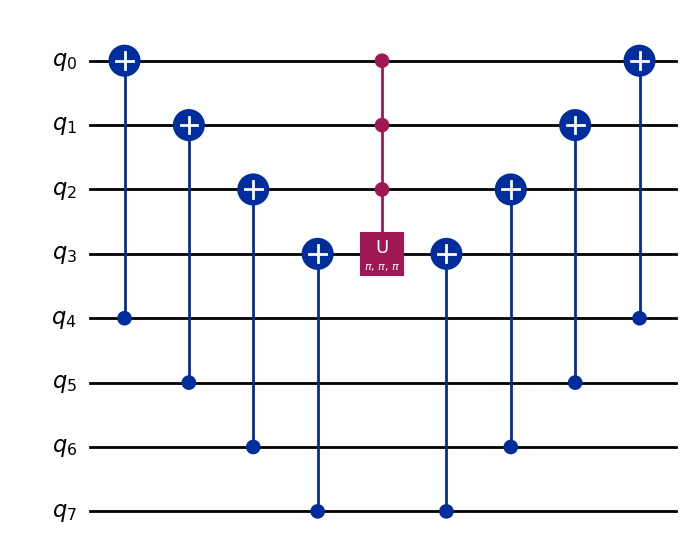

In [46]:
N=8
dt=0.01
V=1000
pot=potential_xy(N,V,dt)
qc=pot.definition
qc.draw('mpl')

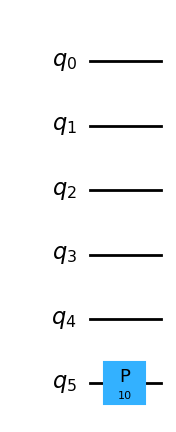

In [47]:
N=6
dt=0.01
V=1000
pot=potential_op(N,V,dt)
qc=pot.definition
qc.draw('mpl')

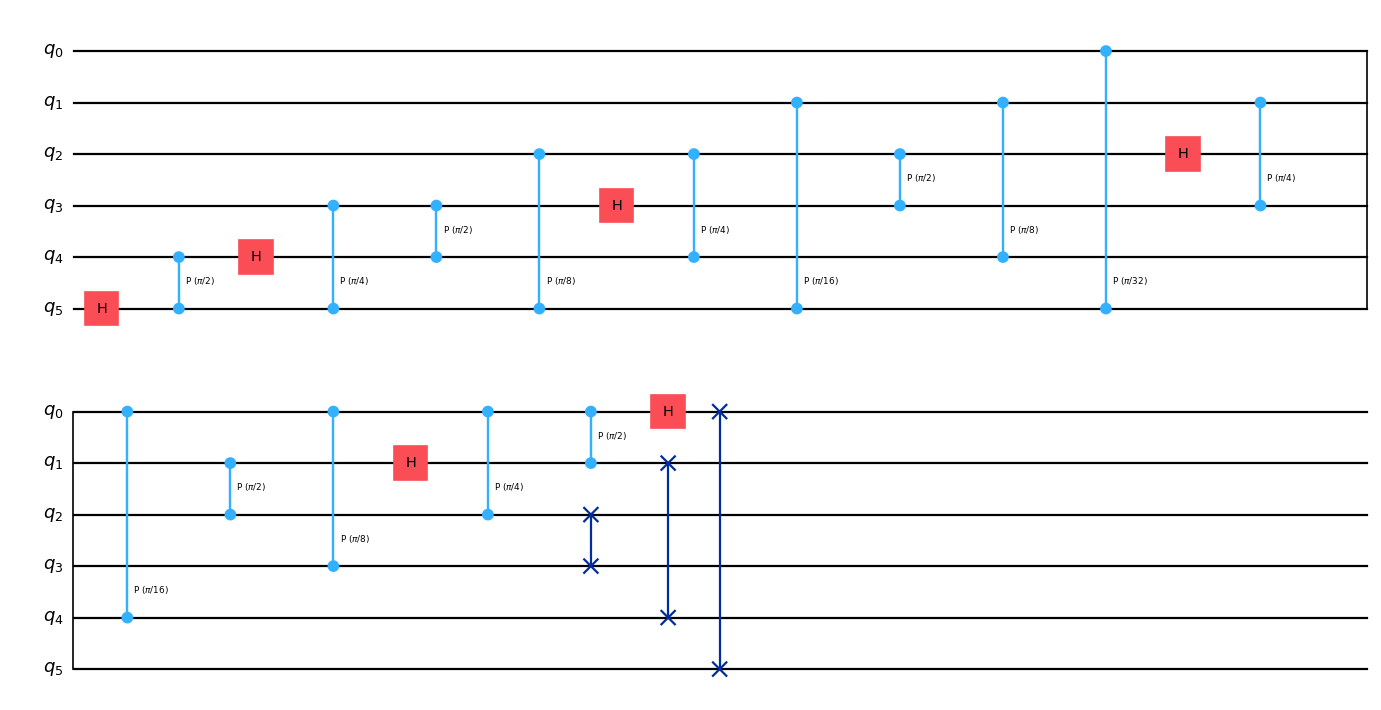

In [48]:
N=6
qft=QFT(6)#quantum fuorier transform
qc=qft.decompose()
qc.draw('mpl', scale=0.8)

In [49]:
def momentum_op(N):
    """N=quibits"""
    qc=q.QuantumCircuit(N+1)
    qc.x(N)
    for i in range (1,N+1):
        qc.p((np.pi/4)*(2**(i-1)),1)
    for i in range(1,N+1):
        for j in range (i+1,N+1):
            qc.cx(N+1-j,0)
            qc.cx(N+1-i,0)
            qc.p(2*np.pi/(2**(j-1)),0)
            qc.cx(N+1-i,0)
            qc.cx(N+1-j,0)
    qc.x(N)
    qc=qc.to_gate()
    qc.name="momentum"
    return qc
            
            

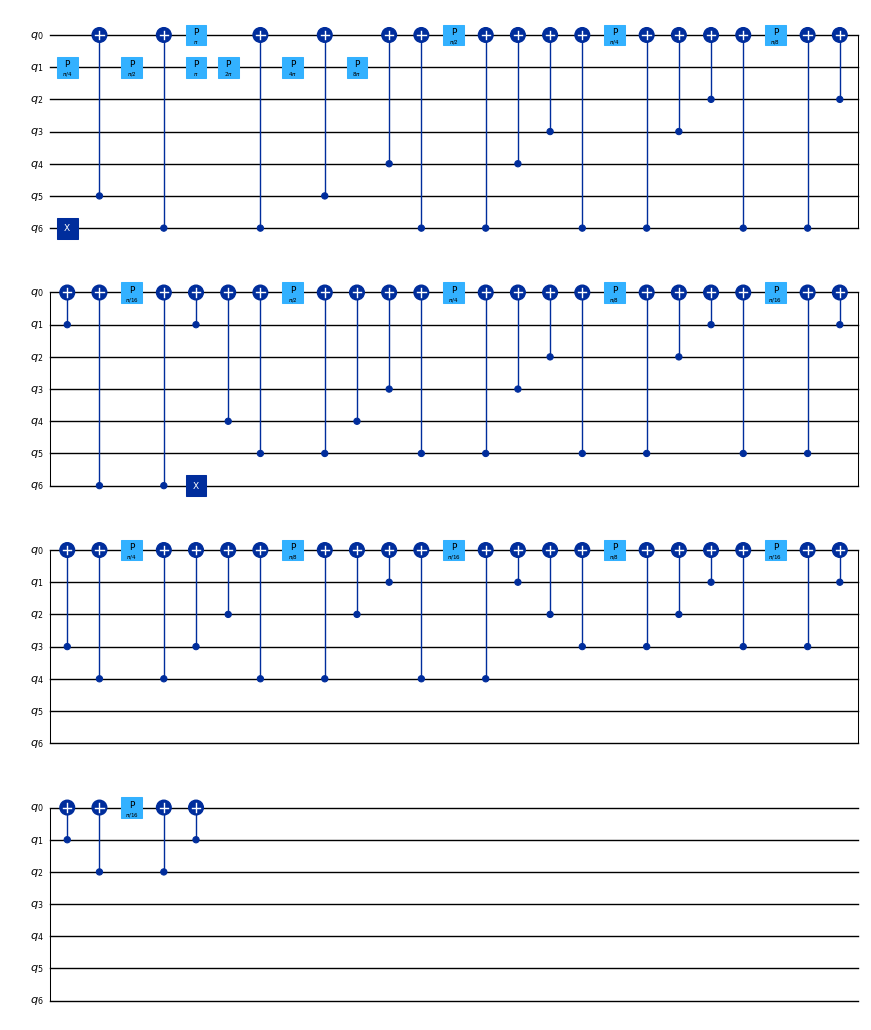

In [50]:
N=6

momentum=momentum_op(N)
qc=momentum.definition
qc.draw('mpl',scale=0.5)

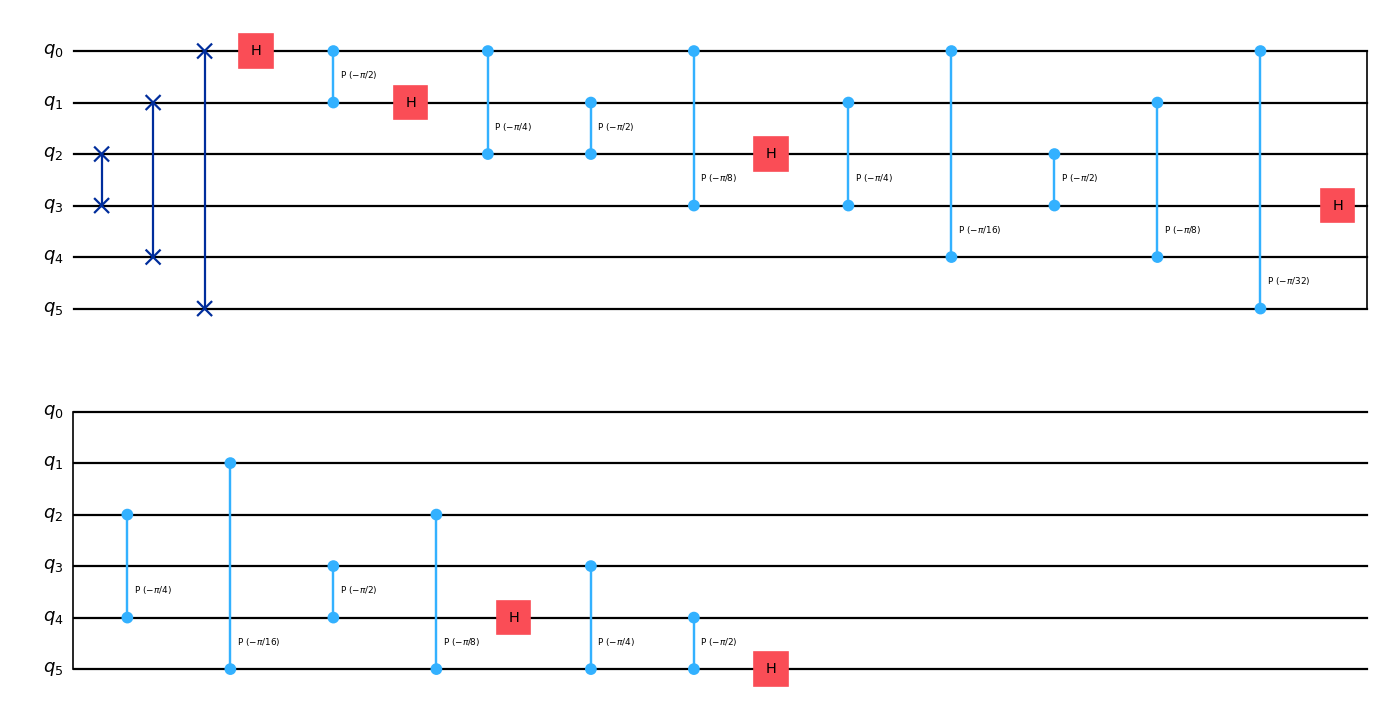

In [51]:
N=6
iqft=QFT(N).inverse()
qc=iqft.decompose()
qc.draw('mpl',scale=0.8)

In [52]:
from qiskit.primitives import Sampler

def probability_distro(qc, shots=1024):
    '''Measurement of probabilities in given qc.
    shots = number of repetitions of measurement process
    counts = probability distribution result from measuring each qubit'''
    
    # Initialize the Sampler
    sampler = Sampler()
    
    # Run the circuit using the Sampler
    result = sampler.run(qc, shots=shots).result()
    
    # Get the quasi-probabilities from the result
    quasi_probs = result.quasi_dists
    
    # Convert quasi-probabilities to counts (if needed)
    counts = [{key: int(value * shots) for key, value in quasi_prob.items()} for quasi_prob in quasi_probs]
    answer=counts[0]
    
    return answer

In [53]:
import qiskit as q
from qiskit.circuit.library import QFT

def main_algo(N, dt, V, init_state, times):
    # Create two separate registers with N/2 qubits each
    qr1 = q.QuantumRegister(N//2, name="qubit1")
    qr2 = q.QuantumRegister(N//2, name="qubit2")
    
    ans = q.QuantumRegister(1, name="ancilla")
    cr = q.ClassicalRegister(N, name="cbit")
    circ = q.QuantumCircuit(ans, qr1, qr2, cr)
    
    # Initialization of the first N/2 qubits
    circ.initialize(init_state, qr1[:] + qr2[:])
    # Initialization of the other N/2 qubits with the same initial state
    #circ.initialize(init_state, qr2)
    
    for i in range(times):
        # Apply potential, QFT, momentum, and inverse QFT operations on the first N/2 qubits
        #pot = potential_op(N//2, V, dt)
        #circ.append(pot, qr1)
        qft = QFT(N//2)
        circ.append(qft, qr1)
        momentum = momentum_op(N//2)
        circ.append(momentum, range((N//2)+1))
        iqft = QFT(N//2).inverse()
        circ.append(iqft, qr1)
        
        # Apply potential, QFT, momentum, and inverse QFT operations on the other N/2 qubits
        #pot = potential_op(N//2, V, dt)
        #circ.append(pot, qr2)
        qft = QFT(N//2)
        circ.append(qft, qr2)
        momentum = momentum_op(N//2)
        circ.append(momentum, range((N//2),N+1))
        iqft = QFT(N//2).inverse()
        circ.append(iqft, qr2)
        
        # Apply potential_xy operator on all qubits
        potxy = potential_xy(N,V,dt)
        circ.append(potxy, qr1[:] + qr2[:])
    
    # Measure only the relevant qubits
    circ.measure(qr1[:] + qr2[:], cr)
    answer = probability_distro(circ, shots=65536)
    
    return answer
    
    


In [54]:
import numpy as np

def two_gaussian_wavefunc(x, p, mu1, mu2, sigma):
    """
    Wavefunction with two Gaussian peaks.

    Args:
        x: The point at which we calculate the wavefunction.
        p: The momentum of the reflected wave e^(ipx).
        mu1: Center position of the first Gaussian peak.
        mu2: Center position of the second Gaussian peak.
        sigma: The uncertainty in particle position (common for both peaks).
    
    Returns:
        amp: The normalized probability amplitude.
    """
    # Create two Gaussian components
    gaussian1 = np.exp(-0.5 * (((x - mu1) / sigma) ** 2))
    gaussian2 = np.exp(-0.5 * (((x - mu2) / sigma) ** 2))

    # Combine the Gaussians with a superposition
    amp = (gaussian1 + gaussian2) * np.exp(1j * p * x)

    # Normalize the amplitude
    norm_const = np.sqrt(np.sum(np.abs(amp ** 2)))
    amp /= norm_const

    return amp


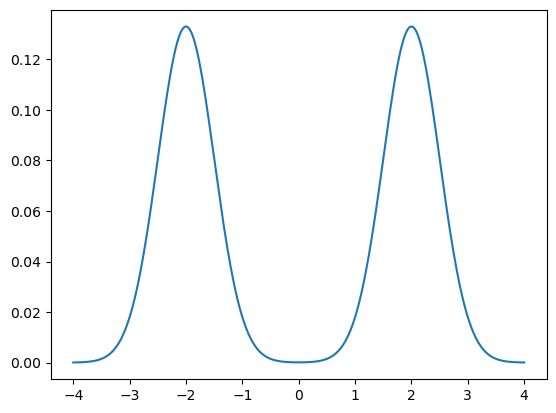

In [55]:
mu1 = -2
mu2=2
sigma = 0.5
p = 0
N = 8

x = np.linspace(-4,4, num=2**N)
init_state2 = two_gaussian_wavefunc(x, p, mu1, mu2, sigma)

plt.plot(x,init_state2)
plt.show()

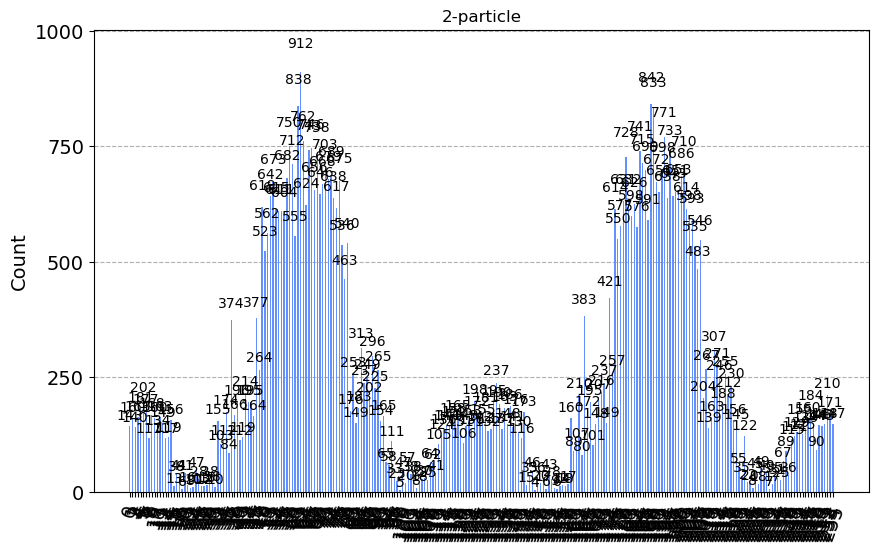

In [56]:
N=8
dt=0.01
V=10000
times=1
k=main_algo(N,dt,V,init_state2,times)

plot_histogram(k, title="2-particle", figsize=[10, 6])
